In [60]:
pip install pandas numpy nltk scikit-learn torch matplotlib tqdm

Note: you may need to restart the kernel to use updated packages.


In [61]:
import pandas as pd

train_df = pd.read_json('train.json')
train_df

,reviews,sentiments
0,I bought this belt for my daughter in-law for ...,1
1,The size was perfect and so was the color. It...,1
2,"Fits and feels good, esp. for doing a swim rac...",1
3,These socks are absolutely the best. I take pi...,1
4,Thank you so much for the speedy delivery they...,1
...,...,...
7396,"I bought these shirts (black, medium) to wear ...",0
7397,"At first, I thought this scarf might not be th...",1
7398,I am very picky when it comes to bras. I want...,1
7399,"This jacket is wind and water resistant, but n...",0


In [62]:
test_df = pd.read_json('test.json')
test_df.head()

,reviews
0,I bought 2 sleepers. sleeper had holes in the...
1,I dare say these are just about the sexiest th...
2,"everything about the transaction (price, deliv..."
3,"Not bad for just a shirt. Very durable, and m..."
4,These are truly wrinkle free and longer than t...


In [63]:
# cell 1
import json
import pandas as pd
import numpy as np
import re
import os

# NLP tools
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Ensure necessary NLTK data are available
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/whiskeyone/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/whiskeyone/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/whiskeyone/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [64]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


In [65]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Fixed: use raw string for regex
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(tokens)



In [66]:
train_df['cleaned_reviews'] = train_df['reviews'].apply(preprocess_text)
test_df['cleaned_reviews'] = test_df['reviews'].apply(preprocess_text)

In [67]:
train_df.head()

,reviews,sentiments,cleaned_reviews
0,I bought this belt for my daughter in-law for ...,1,bought belt daughter inlaw christmas loved
1,The size was perfect and so was the color. It...,1,size perfect color looked like web page
2,"Fits and feels good, esp. for doing a swim rac...",1,fit feel good esp swim race highly recommend c...
3,These socks are absolutely the best. I take pi...,1,sock absolutely best take pilate class hot foo...
4,Thank you so much for the speedy delivery they...,1,thank much speedy delivery came time rehearsal...


In [68]:
test_df.head()

,reviews,cleaned_reviews
0,I bought 2 sleepers. sleeper had holes in the...,bought sleeper sleeper hole arm pit area sleep...
1,I dare say these are just about the sexiest th...,dare say sexiest thing ive ever worn oh ive gs...
2,"everything about the transaction (price, deliv...",everything transaction price delivery time qua...
3,"Not bad for just a shirt. Very durable, and m...",bad shirt durable matched team color perfectly...
4,These are truly wrinkle free and longer than t...,truly wrinkle free longer average woman botton...


In [69]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_df['cleaned_reviews']).toarray()
X_test = vectorizer.transform(test_df['cleaned_reviews']).toarray()

In [70]:

np.save("X_train.npy", X_train)
np.save("X_test.npy", X_test)


In [71]:
# Check type first
print(type(X_train), type(X_test))

# If sparse matrix, convert to array for printing
if hasattr(X_train, "toarray"):
    print("X_train TF-IDF (first 5 rows):")
    print(X_train[:5].toarray())
else:
    print("X_train TF-IDF (first 5 rows):")
    print(X_train[:5])

if hasattr(X_test, "toarray"):
    print("X_test TF-IDF (first 5 rows):")
    print(X_test[:5].toarray())
else:
    print("X_test TF-IDF (first 5 rows):")
    print(X_test[:5])

# Optional: show feature names
print("First 20 TF-IDF feature names:")
print(vectorizer.get_feature_names_out()[:20])


<class 'numpy.ndarray'> <class 'numpy.ndarray'>
X_train TF-IDF (first 5 rows):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
X_test TF-IDF (first 5 rows):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
First 20 TF-IDF feature names:
['aa' 'aaa' 'ab' 'abdomen' 'ability' 'able' 'absolute' 'absolutely'
 'absolutley' 'absorb' 'absorbent' 'absorption' 'abuse' 'ac' 'accent'
 'accentuate' 'accept' 'acceptable' 'access' 'accessible']


## RNN and GRU Model Training

Now we'll implement RNN and GRU models for sentiment classification, testing multiple hyperparameter configurations and selecting the best model.


### Import PyTorch Libraries


In [72]:
# Install PyTorch if needed
# pip install torch

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
from datetime import datetime

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


### Build Vocabulary and Convert to Sequences

Note: We use the cleaned_reviews from above, but build sequences (not TF-IDF) since RNN/GRU need sequences.


In [73]:
# Use cleaned_reviews that we already created above
train_texts = train_df['cleaned_reviews'].tolist()
test_texts = test_df['cleaned_reviews'].tolist()
train_labels = train_df['sentiments'].tolist()

print(f"Training samples: {len(train_texts)}")
print(f"Test samples: {len(test_texts)}")
print(f"Label distribution: {Counter(train_labels)}")


Training samples: 7401
Test samples: 1851
Label distribution: Counter({1: 6319, 0: 1082})


In [74]:
# Build vocabulary from training data
def build_vocab(texts, min_freq=2):
    """Build vocabulary from texts"""
    word_counts = Counter()
    for text in texts:
        words = str(text).lower().split()
        word_counts.update(words)
    
    # Create word to index mapping
    vocab = {'<PAD>': 0, '<UNK>': 1}
    idx = 2
    for word, count in word_counts.items():
        if count >= min_freq:
            vocab[word] = idx
            idx += 1
    
    return vocab

# Build vocabulary
vocab = build_vocab(train_texts, min_freq=2)
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

# Create reverse mapping (index to word) for debugging
idx_to_word = {idx: word for word, idx in vocab.items()}


Vocabulary size: 6714


In [75]:
def text_to_sequence(text, vocab, max_length=200):
    """Convert text to sequence of indices"""
    words = str(text).lower().split()
    sequence = [vocab.get(word, vocab['<UNK>']) for word in words]
    
    # Pad or truncate to max_length
    if len(sequence) < max_length:
        sequence = sequence + [vocab['<PAD>']] * (max_length - len(sequence))
    else:
        sequence = sequence[:max_length]
    
    return sequence

# Convert texts to sequences
max_length = 200
X_train_seq = np.array([text_to_sequence(text, vocab, max_length) for text in train_texts])
X_test_seq = np.array([text_to_sequence(text, vocab, max_length) for text in test_texts])
y_train = np.array(train_labels)

print(f"Training sequences shape: {X_train_seq.shape}")
print(f"Test sequences shape: {X_test_seq.shape}")


Training sequences shape: (7401, 200)
Test sequences shape: (1851, 200)


### Dataset and DataLoader Classes


In [76]:
class SentimentDataset(Dataset):
    """Dataset class for sentiment analysis"""
    def __init__(self, sequences, labels=None):
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = torch.LongTensor(self.sequences[idx])
        if self.labels is not None:
            # Return label as scalar (not tensor with shape [1]) to match model output shape
            label = torch.tensor(self.labels[idx], dtype=torch.float)
            return sequence, label
        return sequence

def create_data_loaders(X_train, y_train, X_val, y_val, batch_size=64):
    """Create train and validation data loaders"""
    train_dataset = SentimentDataset(X_train, y_train)
    val_dataset = SentimentDataset(X_val, y_val)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader


### Model Definitions


In [77]:
class RNNModel(nn.Module):
    """Simple RNN model for sentiment analysis"""
    def __init__(self, vocab_size, embedding_dim=128, hidden_size=64, num_layers=1, dropout=0.0):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_size, num_layers, 
                         batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # x shape: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        rnn_out, hidden = self.rnn(embedded)  # rnn_out: (batch_size, seq_length, hidden_size)
        
        # Use the last output
        last_output = rnn_out[:, -1, :]  # (batch_size, hidden_size)
        last_output = self.dropout(last_output)
        output = self.fc(last_output)  # (batch_size, 1)
        return torch.sigmoid(output)

class GRUModel(nn.Module):
    """GRU model for sentiment analysis"""
    def __init__(self, vocab_size, embedding_dim=128, hidden_size=64, num_layers=1, dropout=0.0):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers, 
                          batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # x shape: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        gru_out, hidden = self.gru(embedded)  # gru_out: (batch_size, seq_length, hidden_size)
        
        # Use the last output
        last_output = gru_out[:, -1, :]  # (batch_size, hidden_size)
        last_output = self.dropout(last_output)
        output = self.fc(last_output)  # (batch_size, 1)
        return torch.sigmoid(output)


### Training and Evaluation Functions


In [98]:
def train_model(model, train_loader, val_loader, epochs=3, learning_rate=0.001, 
                device='cpu', verbose=True):
    """Train a model and return training history"""
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': []
    }
    
    best_val_f1 = 0.0
    best_model_state = None
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_preds = []
        train_true = []
        
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]") if verbose else train_loader
        for sequences, labels in train_pbar:
            sequences = sequences.to(device)
            labels = labels.to(device)  # Already float from dataset
            
            optimizer.zero_grad()
            outputs = model(sequences).squeeze()  # Shape: [batch_size]
            loss = criterion(outputs, labels)  # labels shape: [batch_size]
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            preds = (outputs > 0.5).float()
            train_preds.extend(preds.cpu().numpy())
            train_true.extend(labels.cpu().numpy())
        
        avg_train_loss = train_loss / len(train_loader)
        train_acc = accuracy_score(train_true, train_preds)
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_preds = []
        val_true = []
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]") if verbose else val_loader
            for sequences, labels in val_pbar:
                sequences = sequences.to(device)
                labels = labels.to(device)  # Already float from dataset
                
                outputs = model(sequences).squeeze()  # Shape: [batch_size]
                loss = criterion(outputs, labels)  # labels shape: [batch_size]
                
                val_loss += loss.item()
                preds = (outputs > 0.5).float()
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(val_true, val_preds)
        val_precision = precision_score(val_true, val_preds, average='weighted', zero_division=0)
        val_recall = recall_score(val_true, val_preds, average='weighted', zero_division=0)
        val_f1 = f1_score(val_true, val_preds, average='weighted', zero_division=0)
        
        # Update history
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)
        
        if verbose:
            print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")
        
        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = model.state_dict().copy()
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, history

def evaluate_model(model, test_loader, device='cpu'):
    """Evaluate model on test set or validation set"""
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for batch in test_loader:
            # Handle both cases: (sequences, labels) or just sequences
            if isinstance(batch, (list, tuple)) and len(batch) == 2:
                sequences, _ = batch  # Unpack if labels are present
            else:
                sequences = batch  # Just sequences
            
            sequences = sequences.to(device)
            outputs = model(sequences).squeeze()
            preds = (outputs > 0.5).float()
            predictions.extend(preds.cpu().numpy().astype(int))
    
    return predictions


### Split Data and Define Hyperparameter Configurations


In [79]:
# Split training data into train and validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_seq, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Train split: {len(X_train_split)}")
print(f"Validation split: {len(X_val_split)}")


Train split: 5920
Validation split: 1481


In [80]:
# Define experiment configurations
experiment_configs = [
    {
        'experiment_name': 'RNN_Base',
        'model_type': 'RNN',
        'embedding_dim': 128,
        'hidden_size': 64,
        'num_layers': 1,
        'dropout': 0.0,
        'batch_size': 64,
        'learning_rate': 0.001,
        'epochs': 5
    },
    {
        'experiment_name': 'RNN_Large',
        'model_type': 'RNN',
        'embedding_dim': 128,
        'hidden_size': 128,
        'num_layers': 2,
        'dropout': 0.2,
        'batch_size': 64,
        'learning_rate': 0.001,
        'epochs': 5
    },
    {
        'experiment_name': 'GRU_Base',
        'model_type': 'GRU',
        'embedding_dim': 128,
        'hidden_size': 64,
        'num_layers': 1,
        'dropout': 0.0,
        'batch_size': 64,
        'learning_rate': 0.001,
        'epochs': 5
    },
    {
        'experiment_name': 'GRU_Large',
        'model_type': 'GRU',
        'embedding_dim': 128,
        'hidden_size': 128,
        'num_layers': 2,
        'dropout': 0.2,
        'batch_size': 64,
        'learning_rate': 0.001,
        'epochs': 5
    },
    {
        'experiment_name': 'GRU_HighLR',
        'model_type': 'GRU',
        'embedding_dim': 128,
        'hidden_size': 64,
        'num_layers': 1,
        'dropout': 0.0,
        'batch_size': 64,
        'learning_rate': 0.01,
        'epochs': 5
    },
    {
        'experiment_name': 'RNN_HighLR',
        'model_type': 'RNN',
        'embedding_dim': 128,
        'hidden_size': 64,
        'num_layers': 1,
        'dropout': 0.0,
        'batch_size': 64,
        'learning_rate': 0.01,
        'epochs': 5
    }
]

print(f"Testing {len(experiment_configs)} configurations")


Testing 6 configurations


### Run Hyperparameter Search


In [81]:
# Run hyperparameter search
all_results = {}
best_score = -1
best_model = None
best_config = None
best_history = None

print(f"\n{'='*80}")
print(f"HYPERPARAMETER SEARCH - Testing {len(experiment_configs)} configurations")
print(f"{'='*80}\n")

for i, config in enumerate(experiment_configs):
    exp_name = config['experiment_name']
    print(f"\n{'='*80}")
    print(f"Experiment {i+1}/{len(experiment_configs)}: {exp_name}")
    print(f"{'='*80}")
    print(f"Model: {config['model_type']}, Hidden: {config['hidden_size']}, "
          f"LR: {config['learning_rate']}, Batch: {config['batch_size']}")
    
    # Create data loaders
    train_loader, val_loader = create_data_loaders(
        X_train_split, y_train_split, X_val_split, y_val_split, 
        batch_size=config['batch_size']
    )
    
    # Create model
    if config['model_type'] == 'RNN':
        model = RNNModel(
            vocab_size=vocab_size,
            embedding_dim=config['embedding_dim'],
            hidden_size=config['hidden_size'],
            num_layers=config['num_layers'],
            dropout=config['dropout']
        )
    else:  # GRU
        model = GRUModel(
            vocab_size=vocab_size,
            embedding_dim=config['embedding_dim'],
            hidden_size=config['hidden_size'],
            num_layers=config['num_layers'],
            dropout=config['dropout']
        )
    
    # Train model
    trained_model, history = train_model(
        model, train_loader, val_loader,
        epochs=config['epochs'],
        learning_rate=config['learning_rate'],
        device=device,
        verbose=True
    )
    
    # Get best score
    best_val_f1 = max(history['val_f1'])
    
    # Store results
    all_results[exp_name] = {
        'config': config,
        'history': history,
        'model': trained_model,
        'best_val_f1': best_val_f1,
        'final_val_f1': history['val_f1'][-1],
        'final_val_acc': history['val_acc'][-1]
    }
    
    # Check if this is the best model
    if best_val_f1 > best_score:
        best_score = best_val_f1
        best_model = trained_model
        best_config = config
        best_history = history
        print(f"\n✓ New best model! (Val F1: {best_score:.4f})")



HYPERPARAMETER SEARCH - Testing 6 configurations


Experiment 1/6: RNN_Base
Model: RNN, Hidden: 64, LR: 0.001, Batch: 64


Epoch 1/5 [Val]: 100%|██████████| 24/24 [00:00<00:00, 135.24it/s]


Epoch 1: Train Loss: 0.4485, Train Acc: 0.8451 | Val Loss: 0.4290, Val Acc: 0.8528, Val F1: 0.7857


Epoch 2/5 [Val]: 100%|██████████| 24/24 [00:00<00:00, 134.86it/s]


Epoch 2: Train Loss: 0.4182, Train Acc: 0.8542 | Val Loss: 0.4299, Val Acc: 0.8521, Val F1: 0.7853


Epoch 3/5 [Val]: 100%|██████████| 24/24 [00:00<00:00, 136.04it/s]


Epoch 3: Train Loss: 0.4154, Train Acc: 0.8544 | Val Loss: 0.4311, Val Acc: 0.8528, Val F1: 0.7857


Epoch 4/5 [Val]: 100%|██████████| 24/24 [00:00<00:00, 134.66it/s]


Epoch 4: Train Loss: 0.4168, Train Acc: 0.8544 | Val Loss: 0.4313, Val Acc: 0.8528, Val F1: 0.7857


Epoch 5/5 [Val]: 100%|██████████| 24/24 [00:00<00:00, 133.98it/s]


Epoch 5: Train Loss: 0.4155, Train Acc: 0.8544 | Val Loss: 0.4303, Val Acc: 0.8528, Val F1: 0.7857

✓ New best model! (Val F1: 0.7857)

Experiment 2/6: RNN_Large
Model: RNN, Hidden: 128, LR: 0.001, Batch: 64


Epoch 1/5 [Val]: 100%|██████████| 24/24 [00:00<00:00, 50.00it/s]


Epoch 1: Train Loss: 0.4286, Train Acc: 0.8492 | Val Loss: 0.4346, Val Acc: 0.8535, Val F1: 0.7860


Epoch 2/5 [Val]: 100%|██████████| 24/24 [00:00<00:00, 47.71it/s]


Epoch 2: Train Loss: 0.4171, Train Acc: 0.8541 | Val Loss: 0.4297, Val Acc: 0.8535, Val F1: 0.7860


Epoch 3/5 [Val]: 100%|██████████| 24/24 [00:00<00:00, 50.34it/s]


Epoch 3: Train Loss: 0.4176, Train Acc: 0.8542 | Val Loss: 0.4295, Val Acc: 0.8535, Val F1: 0.7860


Epoch 4/5 [Val]: 100%|██████████| 24/24 [00:00<00:00, 27.83it/s]


Epoch 4: Train Loss: 0.4183, Train Acc: 0.8544 | Val Loss: 0.4316, Val Acc: 0.8535, Val F1: 0.7860


Epoch 5/5 [Val]: 100%|██████████| 24/24 [00:00<00:00, 29.87it/s]


Epoch 5: Train Loss: 0.4190, Train Acc: 0.8544 | Val Loss: 0.4301, Val Acc: 0.8535, Val F1: 0.7860

✓ New best model! (Val F1: 0.7860)

Experiment 3/6: GRU_Base
Model: GRU, Hidden: 64, LR: 0.001, Batch: 64


Epoch 1/5 [Val]: 100%|██████████| 24/24 [00:00<00:00, 76.49it/s]


Epoch 1: Train Loss: 0.4833, Train Acc: 0.8539 | Val Loss: 0.4294, Val Acc: 0.8535, Val F1: 0.7860


Epoch 2/5 [Val]: 100%|██████████| 24/24 [00:00<00:00, 71.07it/s]


Epoch 2: Train Loss: 0.4162, Train Acc: 0.8542 | Val Loss: 0.4291, Val Acc: 0.8535, Val F1: 0.7860


Epoch 3/5 [Val]: 100%|██████████| 24/24 [00:00<00:00, 71.02it/s]


Epoch 3: Train Loss: 0.4162, Train Acc: 0.8544 | Val Loss: 0.4293, Val Acc: 0.8535, Val F1: 0.7860


Epoch 4/5 [Val]: 100%|██████████| 24/24 [00:00<00:00, 76.38it/s]


Epoch 4: Train Loss: 0.4157, Train Acc: 0.8544 | Val Loss: 0.4291, Val Acc: 0.8535, Val F1: 0.7860


Epoch 5/5 [Val]: 100%|██████████| 24/24 [00:00<00:00, 74.74it/s]


Epoch 5: Train Loss: 0.4157, Train Acc: 0.8544 | Val Loss: 0.4308, Val Acc: 0.8535, Val F1: 0.7860

Experiment 4/6: GRU_Large
Model: GRU, Hidden: 128, LR: 0.001, Batch: 64


Epoch 1/5 [Val]: 100%|██████████| 24/24 [00:00<00:00, 24.63it/s]


Epoch 1: Train Loss: 0.4314, Train Acc: 0.8539 | Val Loss: 0.4314, Val Acc: 0.8535, Val F1: 0.7860


Epoch 2/5 [Val]: 100%|██████████| 24/24 [00:00<00:00, 24.98it/s]


Epoch 2: Train Loss: 0.4186, Train Acc: 0.8542 | Val Loss: 0.4288, Val Acc: 0.8535, Val F1: 0.7860


Epoch 3/5 [Val]: 100%|██████████| 24/24 [00:00<00:00, 24.11it/s]


Epoch 3: Train Loss: 0.4160, Train Acc: 0.8544 | Val Loss: 0.4291, Val Acc: 0.8535, Val F1: 0.7860


Epoch 4/5 [Val]: 100%|██████████| 24/24 [00:00<00:00, 25.30it/s]


Epoch 4: Train Loss: 0.4179, Train Acc: 0.8544 | Val Loss: 0.4303, Val Acc: 0.8535, Val F1: 0.7860


Epoch 5/5 [Val]: 100%|██████████| 24/24 [00:00<00:00, 26.01it/s]


Epoch 5: Train Loss: 0.4161, Train Acc: 0.8544 | Val Loss: 0.4290, Val Acc: 0.8535, Val F1: 0.7860

Experiment 5/6: GRU_HighLR
Model: GRU, Hidden: 64, LR: 0.01, Batch: 64


Epoch 1/5 [Val]: 100%|██████████| 24/24 [00:00<00:00, 76.13it/s]


Epoch 1: Train Loss: 0.4348, Train Acc: 0.8481 | Val Loss: 0.4320, Val Acc: 0.8535, Val F1: 0.7860


Epoch 2/5 [Val]: 100%|██████████| 24/24 [00:00<00:00, 77.49it/s]


Epoch 2: Train Loss: 0.3842, Train Acc: 0.8554 | Val Loss: 0.3393, Val Acc: 0.8697, Val F1: 0.8490


Epoch 3/5 [Val]: 100%|██████████| 24/24 [00:00<00:00, 77.91it/s]


Epoch 3: Train Loss: 0.2645, Train Acc: 0.8973 | Val Loss: 0.2858, Val Acc: 0.8893, Val F1: 0.8837


Epoch 4/5 [Val]: 100%|██████████| 24/24 [00:00<00:00, 78.50it/s]


Epoch 4: Train Loss: 0.1670, Train Acc: 0.9412 | Val Loss: 0.2855, Val Acc: 0.8933, Val F1: 0.8912


Epoch 5/5 [Val]: 100%|██████████| 24/24 [00:00<00:00, 78.32it/s]


Epoch 5: Train Loss: 0.0989, Train Acc: 0.9633 | Val Loss: 0.3363, Val Acc: 0.8920, Val F1: 0.8893

✓ New best model! (Val F1: 0.8912)

Experiment 6/6: RNN_HighLR
Model: RNN, Hidden: 64, LR: 0.01, Batch: 64


Epoch 1/5 [Val]: 100%|██████████| 24/24 [00:00<00:00, 137.81it/s]


Epoch 1: Train Loss: 0.4362, Train Acc: 0.8421 | Val Loss: 0.4288, Val Acc: 0.8535, Val F1: 0.7860


Epoch 2/5 [Val]: 100%|██████████| 24/24 [00:00<00:00, 138.34it/s]


Epoch 2: Train Loss: 0.4332, Train Acc: 0.8419 | Val Loss: 0.4692, Val Acc: 0.7839, Val F1: 0.7608


Epoch 3/5 [Val]: 100%|██████████| 24/24 [00:00<00:00, 140.14it/s]


Epoch 3: Train Loss: 0.4231, Train Acc: 0.8515 | Val Loss: 0.4288, Val Acc: 0.8528, Val F1: 0.7857


Epoch 4/5 [Val]: 100%|██████████| 24/24 [00:00<00:00, 139.70it/s]


Epoch 4: Train Loss: 0.4182, Train Acc: 0.8542 | Val Loss: 0.4290, Val Acc: 0.8528, Val F1: 0.7857


Epoch 5/5 [Val]: 100%|██████████| 24/24 [00:00<00:00, 137.44it/s]

Epoch 5: Train Loss: 0.4247, Train Acc: 0.8542 | Val Loss: 0.4286, Val Acc: 0.8528, Val F1: 0.7857


### Results Comparison


In [82]:
# Create comparison DataFrame
comparison_data = []
for exp_name, results in all_results.items():
    comparison_data.append({
        'experiment': exp_name,
        'model_type': results['config']['model_type'],
        'hidden_size': results['config']['hidden_size'],
        'num_layers': results['config']['num_layers'],
        'learning_rate': results['config']['learning_rate'],
        'batch_size': results['config']['batch_size'],
        'best_val_f1': results['best_val_f1'],
        'final_val_f1': results['final_val_f1'],
        'final_val_acc': results['final_val_acc']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('best_val_f1', ascending=False)

print(f"\n{'='*80}")
print("HYPERPARAMETER SEARCH SUMMARY")
print(f"{'='*80}")
print(comparison_df.to_string(index=False))
print(f"\nBest Configuration:")
print(f"  Experiment: {comparison_df.iloc[0]['experiment']}")
print(f"  Model Type: {best_config['model_type']}")
print(f"  Hidden Size: {best_config['hidden_size']}")
print(f"  Learning Rate: {best_config['learning_rate']}")
print(f"  Batch Size: {best_config['batch_size']}")
print(f"  Best Val F1: {best_score:.4f}")



HYPERPARAMETER SEARCH SUMMARY
experiment model_type  hidden_size  num_layers  learning_rate  batch_size  best_val_f1  final_val_f1  final_val_acc
GRU_HighLR        GRU           64           1          0.010          64     0.891157      0.889311       0.891965
 RNN_Large        RNN          128           2          0.001          64     0.786008      0.786008       0.853477
  GRU_Base        GRU           64           1          0.001          64     0.786008      0.786008       0.853477
 GRU_Large        GRU          128           2          0.001          64     0.786008      0.786008       0.853477
RNN_HighLR        RNN           64           1          0.010          64     0.786008      0.785672       0.852802
  RNN_Base        RNN           64           1          0.001          64     0.785672      0.785672       0.852802

Best Configuration:
  Experiment: GRU_HighLR
  Model Type: GRU
  Hidden Size: 64
  Learning Rate: 0.01
  Batch Size: 64
  Best Val F1: 0.8912


### Visualize Training Curves for Best Model


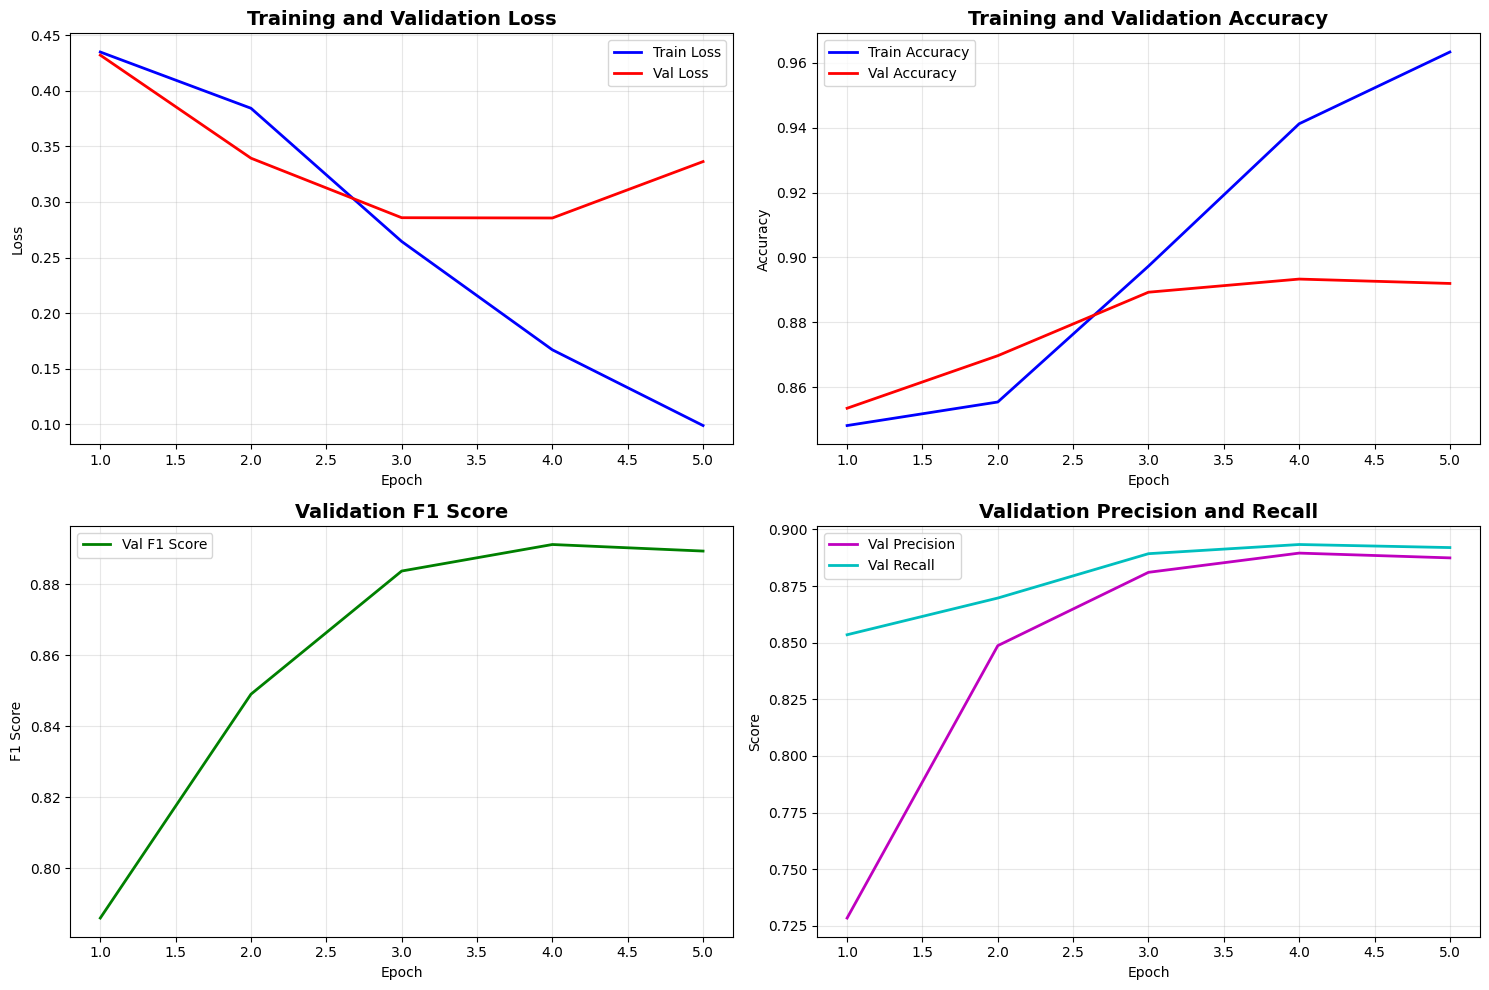


OVERFITTING ANALYSIS
✓ Validation loss not consistently increasing
✓ Validation F1 not consistently decreasing

Best performance at Epoch 4
Final performance at Epoch 5
Performance drop: 0.0018


In [ ]:
# Plot training curves for best model
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

epochs = range(1, len(best_history['train_loss']) + 1)

# Loss curves
axes[0, 0].plot(epochs, best_history['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0, 0].plot(epochs, best_history['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy curves
axes[0, 1].plot(epochs, best_history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
axes[0, 1].plot(epochs, best_history['val_acc'], 'r-', label='Val Accuracy', linewidth=2)
axes[0, 1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# F1 Score
axes[1, 0].plot(epochs, best_history['val_f1'], 'g-', label='Val F1 Score', linewidth=2)
axes[1, 0].set_title('Validation F1 Score', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Precision and Recall
axes[1, 1].plot(epochs, best_history['val_precision'], 'm-', label='Val Precision', linewidth=2)
axes[1, 1].plot(epochs, best_history['val_recall'], 'c-', label='Val Recall', linewidth=2)
axes[1, 1].set_title('Validation Precision and Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze overfitting
print("\n" + "="*80)
print("OVERFITTING ANALYSIS")
print("="*80)
if len(best_history['train_loss']) >= 3:
    # Check if validation loss starts increasing after epoch 3
    val_loss_after_epoch3 = best_history['val_loss'][2:]
    if len(val_loss_after_epoch3) > 1:
        is_increasing = all(val_loss_after_epoch3[i] >= val_loss_after_epoch3[i-1] 
                          for i in range(1, len(val_loss_after_epoch3)))
        if is_increasing:
            print("Overfitting detected: Validation loss increasing after Epoch 3")
        else:
            print("Validation loss not consistently increasing")
    
    # Check validation F1 trend
    val_f1_after_epoch3 = best_history['val_f1'][2:]
    if len(val_f1_after_epoch3) > 1:
        is_decreasing = all(val_f1_after_epoch3[i] <= val_f1_after_epoch3[i-1] 
                          for i in range(1, len(val_f1_after_epoch3)))
        if is_decreasing:
            print("Overfitting detected: Validation F1 decreasing after Epoch 3")
        else:
            print("Validation F1 not consistently decreasing")
    
    print(f"\nBest performance at Epoch {best_history['val_f1'].index(max(best_history['val_f1'])) + 1}")
    print(f"Final performance at Epoch {len(best_history['val_f1'])}")
    print(f"Performance drop: {max(best_history['val_f1']) - best_history['val_f1'][-1]:.4f}")


### Fine-Tune Best Model with Overfitting Mitigation

Based on the analysis above, we'll fine-tune the best model (GRU_HighLR) with:
- **Early Stopping**: Stop training when validation F1 doesn't improve for 2 epochs
- **Learning Rate Scheduling**: Reduce LR by 50% when validation F1 plateaus
- **Increased Regularization**: Add dropout and weight decay
- **More Epochs**: Allow up to 10 epochs but stop early if needed


In [91]:
def train_model_with_early_stopping(model, train_loader, val_loader, epochs=10, learning_rate=0.001, 
                                     device='cpu', verbose=True, patience=2, min_delta=0.0001,
                                     weight_decay=0.01, lr_scheduler_patience=2, lr_factor=0.5):
    """
    Train a model with early stopping and learning rate scheduling to mitigate overfitting
    
    Args:
        model: PyTorch model
        train_loader: Training data loader
        val_loader: Validation data loader
        epochs: Maximum number of epochs
        learning_rate: Initial learning rate
        device: Device to train on
        verbose: Print training progress
        patience: Number of epochs to wait before early stopping
        min_delta: Minimum change to qualify as an improvement
        weight_decay: L2 regularization strength
        lr_scheduler_patience: Patience for learning rate reduction
        lr_factor: Factor to reduce learning rate by
    """
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Learning rate scheduler - reduces LR when validation F1 plateaus
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=lr_factor, patience=lr_scheduler_patience, 
        min_lr=1e-6
    )
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': [],
        'learning_rates': []
    }
    
    best_val_f1 = 0.0
    best_model_state = None
    best_epoch = 0
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_preds = []
        train_true = []
        
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]") if verbose else train_loader
        for sequences, labels in train_pbar:
            sequences = sequences.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(sequences).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            optimizer.step()
            
            train_loss += loss.item()
            preds = (outputs > 0.5).float()
            train_preds.extend(preds.cpu().numpy())
            train_true.extend(labels.cpu().numpy())
        
        avg_train_loss = train_loss / len(train_loader)
        train_acc = accuracy_score(train_true, train_preds)
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_preds = []
        val_true = []
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]") if verbose else val_loader
            for sequences, labels in val_pbar:
                sequences = sequences.to(device)
                labels = labels.to(device)
                
                outputs = model(sequences).squeeze()
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                preds = (outputs > 0.5).float()
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(val_true, val_preds)
        val_precision = precision_score(val_true, val_preds, average='weighted', zero_division=0)
        val_recall = recall_score(val_true, val_preds, average='weighted', zero_division=0)
        val_f1 = f1_score(val_true, val_preds, average='weighted', zero_division=0)
        
        # Update learning rate scheduler
        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_f1)
        new_lr = optimizer.param_groups[0]['lr']
        
        # Update history
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)
        history['learning_rates'].append(current_lr)
        
        if verbose:
            lr_change = f" (LR: {current_lr:.6f})" if new_lr != current_lr else f" (LR: {current_lr:.6f})"
            print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}{lr_change}")
            if new_lr != current_lr:
                print(f"  → Learning rate reduced to {new_lr:.6f}")
        
        # Check for improvement
        if val_f1 > best_val_f1 + min_delta:
            best_val_f1 = val_f1
            best_epoch = epoch + 1
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            if verbose:
                print(f"  ✓ New best model! (Val F1: {best_val_f1:.4f})")
        else:
            patience_counter += 1
            if verbose:
                print(f"  No improvement for {patience_counter} epoch(s)")
        
        # Early stopping
        if patience_counter >= patience:
            if verbose:
                print(f"\nEarly stopping triggered at epoch {epoch+1} (no improvement for {patience} epochs)")
                print(f"   Best model was at epoch {best_epoch} with Val F1: {best_val_f1:.4f}")
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        if verbose:
            print(f"\n✓ Loaded best model from epoch {best_epoch}")
    
    return model, history, best_epoch


In [93]:
# Fine-tune the best model with overfitting mitigation
print(f"\n{'='*80}")
print("FINE-TUNING BEST MODEL (GRU_HighLR) WITH OVERFITTING MITIGATION")
print(f"{'='*80}\n")

# Create fine-tuned model with same architecture as best model
# Start from best model's weights, then apply regularization
fine_tuned_model = GRUModel(
    vocab_size=vocab_size,
    embedding_dim=best_config['embedding_dim'],
    hidden_size=best_config['hidden_size'],
    num_layers=best_config['num_layers'],
    dropout=0.2  # Increased dropout for regularization
)

# Load the best model's weights to continue training from there
print("Loading best model weights as starting point...")
fine_tuned_model.load_state_dict(best_model.state_dict())
print("✓ Loaded best model weights")
print(f"  Starting from Val F1: {best_score:.4f}")

# Create data loaders
train_loader, val_loader = create_data_loaders(
    X_train_split, y_train_split, X_val_split, y_val_split, 
    batch_size=best_config['batch_size']
)

fine_tune_lr = best_config['learning_rate'] * 0.01
print(f"Using fine-tuning learning rate: {fine_tune_lr:.6f} (10% of original {best_config['learning_rate']:.6f})")

fine_tuned_model, fine_tuned_history, best_epoch = train_model_with_early_stopping(
    fine_tuned_model, train_loader, val_loader,
    epochs=10,
    learning_rate=fine_tune_lr,
    device=device,
    verbose=True,
    patience=4,
    min_delta=0.0001,
    weight_decay=0.01,
    lr_scheduler_patience=2,
    lr_factor=0.5
)

fine_tuned_best_f1 = max(fine_tuned_history['val_f1'])
print(f"\n{'='*80}")
print("FINE-TUNING RESULTS")
print(f"{'='*80}")
print(f"Original Best Val F1: {best_score:.4f}")
print(f"Fine-tuned Best Val F1: {fine_tuned_best_f1:.4f}")
print(f"Improvement: {fine_tuned_best_f1 - best_score:.4f}")
print(f"Best epoch: {best_epoch}")
print(f"Total epochs trained: {len(fine_tuned_history['val_f1'])}")



FINE-TUNING BEST MODEL (GRU_HighLR) WITH OVERFITTING MITIGATION

Loading best model weights as starting point...
✓ Loaded best model weights
  Starting from Val F1: 0.8912
Using fine-tuning learning rate: 0.000100 (10% of original 0.010000)


Epoch 1/10 [Train]:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch 1/10 [Val]: 100%|██████████| 24/24 [00:00<00:00, 74.49it/s]


Epoch 1: Train Loss: 0.0564, Train Acc: 0.9828 | Val Loss: 0.3392, Val Acc: 0.8960, Val F1: 0.8928 (LR: 0.000100)
  ✓ New best model! (Val F1: 0.8928)


Epoch 2/10 [Val]: 100%|██████████| 24/24 [00:00<00:00, 73.45it/s]


Epoch 2: Train Loss: 0.0539, Train Acc: 0.9841 | Val Loss: 0.3429, Val Acc: 0.8967, Val F1: 0.8931 (LR: 0.000100)
  ✓ New best model! (Val F1: 0.8931)


Epoch 3/10 [Val]: 100%|██████████| 24/24 [00:00<00:00, 73.59it/s]


Epoch 3: Train Loss: 0.0525, Train Acc: 0.9845 | Val Loss: 0.3464, Val Acc: 0.8974, Val F1: 0.8937 (LR: 0.000100)
  ✓ New best model! (Val F1: 0.8937)


Epoch 4/10 [Val]: 100%|██████████| 24/24 [00:00<00:00, 74.24it/s]


Epoch 4: Train Loss: 0.0510, Train Acc: 0.9856 | Val Loss: 0.3500, Val Acc: 0.8967, Val F1: 0.8931 (LR: 0.000100)
  No improvement for 1 epoch(s)


Epoch 5/10 [Val]: 100%|██████████| 24/24 [00:00<00:00, 67.40it/s]


Epoch 5: Train Loss: 0.0492, Train Acc: 0.9848 | Val Loss: 0.3531, Val Acc: 0.8974, Val F1: 0.8937 (LR: 0.000100)
  No improvement for 2 epoch(s)


Epoch 6/10 [Val]: 100%|██████████| 24/24 [00:00<00:00, 71.89it/s]


Epoch 6: Train Loss: 0.0477, Train Acc: 0.9872 | Val Loss: 0.3562, Val Acc: 0.8953, Val F1: 0.8917 (LR: 0.000100)
  → Learning rate reduced to 0.000050
  No improvement for 3 epoch(s)


Epoch 7/10 [Val]: 100%|██████████| 24/24 [00:00<00:00, 74.29it/s]

Epoch 7: Train Loss: 0.0457, Train Acc: 0.9863 | Val Loss: 0.3576, Val Acc: 0.8953, Val F1: 0.8917 (LR: 0.000050)
  No improvement for 4 epoch(s)

Early stopping triggered at epoch 7 (no improvement for 4 epochs)
   Best model was at epoch 3 with Val F1: 0.8937

✓ Loaded best model from epoch 3

FINE-TUNING RESULTS
Original Best Val F1: 0.8912
Fine-tuned Best Val F1: 0.8937
Improvement: 0.0025
Best epoch: 3
Total epochs trained: 7


### Compare Original vs Fine-Tuned Model


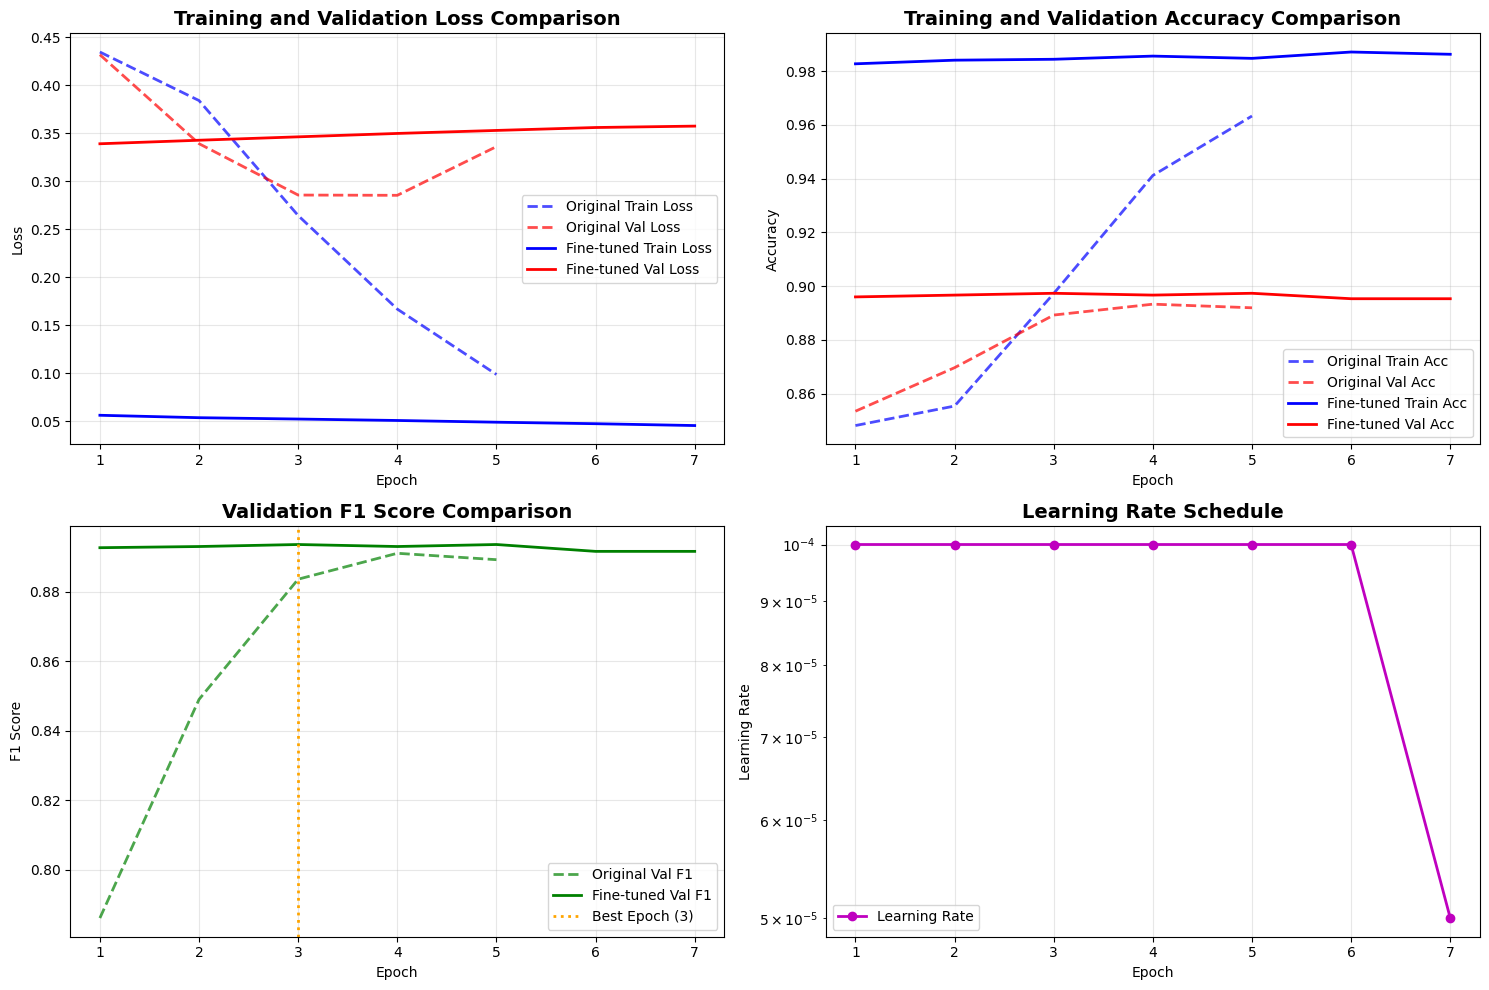


COMPARISON SUMMARY
Metric                    Original        Fine-tuned      Change         
--------------------------------------------------------------------------------
Best Val F1               0.8912          0.8937                  +0.0025
Final Val F1              0.8893          0.8917                  +0.0024
Best Val Acc              0.8933          0.8974                  +0.0041
Epochs Trained            5               7                            +2
Overfitting Gap           0.0714          0.0910                  +0.0196


In [94]:
# Plot comparison: Original vs Fine-tuned
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

epochs_original = range(1, len(best_history['train_loss']) + 1)
epochs_finetuned = range(1, len(fine_tuned_history['train_loss']) + 1)

# Loss curves comparison
axes[0, 0].plot(epochs_original, best_history['train_loss'], 'b--', label='Original Train Loss', linewidth=2, alpha=0.7)
axes[0, 0].plot(epochs_original, best_history['val_loss'], 'r--', label='Original Val Loss', linewidth=2, alpha=0.7)
axes[0, 0].plot(epochs_finetuned, fine_tuned_history['train_loss'], 'b-', label='Fine-tuned Train Loss', linewidth=2)
axes[0, 0].plot(epochs_finetuned, fine_tuned_history['val_loss'], 'r-', label='Fine-tuned Val Loss', linewidth=2)
axes[0, 0].set_title('Training and Validation Loss Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy curves comparison
axes[0, 1].plot(epochs_original, best_history['train_acc'], 'b--', label='Original Train Acc', linewidth=2, alpha=0.7)
axes[0, 1].plot(epochs_original, best_history['val_acc'], 'r--', label='Original Val Acc', linewidth=2, alpha=0.7)
axes[0, 1].plot(epochs_finetuned, fine_tuned_history['train_acc'], 'b-', label='Fine-tuned Train Acc', linewidth=2)
axes[0, 1].plot(epochs_finetuned, fine_tuned_history['val_acc'], 'r-', label='Fine-tuned Val Acc', linewidth=2)
axes[0, 1].set_title('Training and Validation Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# F1 Score comparison
axes[1, 0].plot(epochs_original, best_history['val_f1'], 'g--', label='Original Val F1', linewidth=2, alpha=0.7)
axes[1, 0].plot(epochs_finetuned, fine_tuned_history['val_f1'], 'g-', label='Fine-tuned Val F1', linewidth=2)
axes[1, 0].axvline(x=best_epoch, color='orange', linestyle=':', linewidth=2, label=f'Best Epoch ({best_epoch})')
axes[1, 0].set_title('Validation F1 Score Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Learning rate schedule
axes[1, 1].plot(epochs_finetuned, fine_tuned_history['learning_rates'], 'm-', label='Learning Rate', linewidth=2, marker='o')
axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_yscale('log')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*80)
print("COMPARISON SUMMARY")
print("="*80)
print(f"{'Metric':<25} {'Original':<15} {'Fine-tuned':<15} {'Change':<15}")
print("-"*80)
print(f"{'Best Val F1':<25} {max(best_history['val_f1']):<15.4f} {fine_tuned_best_f1:<15.4f} {fine_tuned_best_f1 - max(best_history['val_f1']):>+15.4f}")
print(f"{'Final Val F1':<25} {best_history['val_f1'][-1]:<15.4f} {fine_tuned_history['val_f1'][-1]:<15.4f} {fine_tuned_history['val_f1'][-1] - best_history['val_f1'][-1]:>+15.4f}")
print(f"{'Best Val Acc':<25} {max(best_history['val_acc']):<15.4f} {max(fine_tuned_history['val_acc']):<15.4f} {max(fine_tuned_history['val_acc']) - max(best_history['val_acc']):>+15.4f}")
print(f"{'Epochs Trained':<25} {len(best_history['val_f1']):<15} {len(fine_tuned_history['val_f1']):<15} {len(fine_tuned_history['val_f1']) - len(best_history['val_f1']):>+15}")
print(f"{'Overfitting Gap':<25} {best_history['train_acc'][-1] - best_history['val_acc'][-1]:<15.4f} {fine_tuned_history['train_acc'][-1] - fine_tuned_history['val_acc'][-1]:<15.4f} {(fine_tuned_history['train_acc'][-1] - fine_tuned_history['val_acc'][-1]) - (best_history['train_acc'][-1] - best_history['val_acc'][-1]):>+15.4f}")


### Update Best Model (Use Fine-Tuned if Better)


In [95]:
# Use fine-tuned model if it's better, otherwise keep original
if fine_tuned_best_f1 > best_score:
    print(f"\n✓ Using fine-tuned model (improvement: {fine_tuned_best_f1 - best_score:.4f})")
    best_model = fine_tuned_model
    best_history = fine_tuned_history
    best_score = fine_tuned_best_f1
    best_config['dropout'] = 0.2  # Update config to reflect fine-tuned settings
    best_config['weight_decay'] = 0.01
    best_config['early_stopping'] = True
    best_config['lr_scheduling'] = True
    best_config['best_epoch'] = best_epoch
else:
    print(f"\n✓ Keeping original model (fine-tuned didn't improve)")
    print(f"  Original: {best_score:.4f}, Fine-tuned: {fine_tuned_best_f1:.4f}")



✓ Using fine-tuned model (improvement: 0.0025)


### Generate Interim Evaluation File (interim.csv)

Before generating the final submission, let's create an interim.csv file with validation set predictions to evaluate model performance.


In [99]:
# Create interim.csv with validation set predictions
# We need to get the original reviews and labels for the validation set
# Use the same split indices to ensure we get the correct validation samples
from sklearn.model_selection import train_test_split

# Get the indices from the original split (same random_state=42)
train_indices, val_indices = train_test_split(
    train_df.index, test_size=0.2, random_state=42, stratify=train_df['sentiments']
)

# Get validation DataFrame using the indices
val_df_split = train_df.loc[val_indices].reset_index(drop=True)

print(f"Validation set size: {len(val_df_split)}")
print(f"Validation label distribution:")
print(val_df_split['sentiments'].value_counts())

# Create validation dataset and loader
val_dataset = SentimentDataset(X_val_split, y_val_split)
val_loader = DataLoader(val_dataset, batch_size=best_config['batch_size'], shuffle=False)

# Generate predictions on validation set
print("\nGenerating predictions for validation set...")
val_predictions = evaluate_model(best_model, val_loader, device=device)

# Create interim DataFrame with 4 columns: reviews, sentiments, predictions, correctness
interim_df = pd.DataFrame({
    'reviews': val_df_split['reviews'].values,  # Original reviews from JSON
    'sentiments': val_df_split['sentiments'].values,  # Actual labels from JSON
    'predictions': val_predictions,  # Model predictions
    'correctness': (val_df_split['sentiments'].values == val_predictions).astype(int)  # 1 if correct, 0 if wrong
})

# Save interim.csv
interim_df.to_csv('interim.csv', index=False)
print(f"\n✓ Interim file saved: interim.csv")
print(f"  Total samples: {len(interim_df)}")
print(f"  Correct predictions: {interim_df['correctness'].sum()} ({interim_df['correctness'].mean()*100:.2f}%)")
print(f"  Incorrect predictions: {(~interim_df['correctness'].astype(bool)).sum()} ({(1-interim_df['correctness'].mean())*100:.2f}%)")
print(f"\nFirst 10 rows:")
print(interim_df.head(10))
print(f"\nSample of incorrect predictions:")
incorrect = interim_df[interim_df['correctness'] == 0]
if len(incorrect) > 0:
    print(incorrect.head(10))
else:
    print("  No incorrect predictions!")


Validation set size: 1481
Validation label distribution:
sentiments
1    1264
0     217
Name: count, dtype: int64

Generating predictions for validation set...

✓ Interim file saved: interim.csv
  Total samples: 1481
  Correct predictions: 1326 (89.53%)
  Incorrect predictions: 155 (10.47%)

First 10 rows:
                                             reviews  sentiments  predictions  \
0  I love this bag!  The quality of the canvas an...           1            1   
1  Great product at a great price!!  Fast shippin...           1            1   
2  I've had two of these and they are great. Trul...           1            1   
3  My son loved these shoes. Even though he is tw...           1            1   
4  The 3 T-Shirts we ordered were not as pictured...           0            0   
5  After years of wanting some overalls my wife g...           1            1   
6  This is my second Rider sandal.  They have a c...           1            1   
7  Both chargers and the A/V cable work well

# only ran up till this point

### Generate Final Predictions and Submission File


In [ ]:
# Create test dataset and loader
test_dataset = SentimentDataset(X_test_seq)
test_loader = DataLoader(test_dataset, batch_size=best_config['batch_size'], shuffle=False)

# Generate predictions using best model (original or fine-tuned)
print("Generating predictions for test set using best model...")
if fine_tuned_best_f1 > best_score:
    print("Using fine-tuned model for predictions")
else:
    print("Using original best model for predictions")

predictions = evaluate_model(best_model, test_loader, device=device)

# Create submission DataFrame
submission_df = pd.DataFrame({
    'reviews': test_df['reviews'],
    'sentiments': predictions
})

# Save submission file
submission_df.to_csv('submission.csv', index=False)
print(f"\nSubmission file saved: submission.csv")
print(f"Predictions shape: {len(predictions)}")
print(f"Sentiment distribution:")
print(submission_df['sentiments'].value_counts())
print(f"\nFirst 10 predictions:")
print(submission_df.head(10))


Generating predictions for test set...

Submission file saved: submission.csv
Predictions shape: 1851
Sentiment distribution:
sentiments
1    1638
0     213
Name: count, dtype: int64

First 10 predictions:
                                             reviews  sentiments
0  I bought 2 sleepers.  sleeper had holes in the...           0
1  I dare say these are just about the sexiest th...           1
2  everything about the transaction (price, deliv...           1
3  Not bad for just a shirt.  Very durable, and m...           1
4  These are truly wrinkle free and longer than t...           1
5  I love naughty monkey! I'm so happy with their...           1
6  I fell in love with this boot when I first saw...           1
7  These shades are a great buy.  Fast shipping, ...           1
8  There was no picture of this selection, so I g...           0
9  This leather briefcase was exactly what I was ...           1


### Save Results Summary


In [ ]:
# Save comparison results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
comparison_df.to_csv(f'hyperparameter_comparison_{timestamp}.csv', index=False)

# Check if fine-tuning was performed
fine_tuned_performed = 'fine_tuned_best_f1' in globals() and 'fine_tuned_history' in globals() and 'best_epoch' in globals()

# Save detailed results including fine-tuning
results_summary = {
    'timestamp': timestamp,
    'best_config': best_config,
    'best_val_f1': best_score,
    'vocab_size': vocab_size,
    'max_length': max_length,
    'fine_tuned': fine_tuned_performed and fine_tuned_best_f1 > max([r['best_val_f1'] for r in all_results.values()]),
    'fine_tuned_val_f1': fine_tuned_best_f1 if (fine_tuned_performed and fine_tuned_best_f1 > best_score) else None,
    'fine_tuned_best_epoch': best_epoch if (fine_tuned_performed and fine_tuned_best_f1 > best_score) else None,
    'all_results': {
        name: {
            'config': results['config'],
            'best_val_f1': results['best_val_f1'],
            'final_val_f1': results['final_val_f1'],
            'final_val_acc': results['final_val_acc']
        }
        for name, results in all_results.items()
    }
}

# Add fine-tuning history if available
if fine_tuned_performed and fine_tuned_best_f1 > best_score:
    results_summary['fine_tuning_history'] = fine_tuned_history

with open(f'results_summary_{timestamp}.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"\nResults saved:")
print(f"  - hyperparameter_comparison_{timestamp}.csv")
print(f"  - results_summary_{timestamp}.json")
print(f"  - submission.csv")
if fine_tuned_performed:
    if fine_tuned_best_f1 > best_score:
        print(f"\n✓ Final model: Fine-tuned GRU (Val F1: {fine_tuned_best_f1:.4f})")
    else:
        print(f"\n✓ Final model: Original best model (Val F1: {best_score:.4f})")



Results saved:
  - hyperparameter_comparison_20251106_200515.csv
  - results_summary_20251106_200515.json
  - submission.csv
